# Book Recommendation System

In [255]:
#Importing modules
import pandas as pd
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import re
import operator
import pickle
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
# This is to supress the warning messages (if any) generated in our code
import warnings
warnings.filterwarnings('ignore')

### Loading Datasets

In [151]:
# Loading Users dataset
users = pd.read_csv("Users.csv")
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [258]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   User-ID  278858 non-null  int64  
 1   Age      278858 non-null  float64
 2   Country  278858 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [152]:
# Loading Books dataset
books = pd.read_csv("Books.csv")
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [259]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 271360 non-null  object 
 1   Book-Title           271360 non-null  object 
 2   Book-Author          271360 non-null  object 
 3   Year-Of-Publication  271360 non-null  float64
 4   Publisher            271360 non-null  object 
dtypes: float64(1), object(4)
memory usage: 10.4+ MB


In [153]:
# Loading Ratings dataset
ratings = pd.read_csv("Ratings.csv")
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [260]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


### Dimensions of datasets

In [154]:

print("Books Data:    ", books.shape)
print("Users Data:    ", users.shape)
print("Books-ratings: ", ratings.shape)

Books Data:     (271360, 8)
Users Data:     (278858, 3)
Books-ratings:  (1149780, 3)


# Preprocessing 

### Users dataset

In [155]:
def missing_values(df):
    mis_val=df.isnull().sum()
    mis_val_percent=round(df.isnull().mean().mul(100),2)
    mz_table=pd.concat([mis_val,mis_val_percent],axis=1)
    mz_table=mz_table.rename(
    columns={df.index.name:'col_name',0:'Missing Values',1:'% of Total Values'})
    mz_table['Data_type']=df.dtypes
    mz_table=mz_table.sort_values('% of Total Values',ascending=False)
    return mz_table.reset_index()

In [156]:
missing_values(users)

,index,Missing Values,% of Total Values,Data_type
0,Age,110762,39.72,float64
1,User-ID,0,0.00,int64
2,Location,0,0.00,object


Age has 39.72% of missing values 

#### Age Distribution

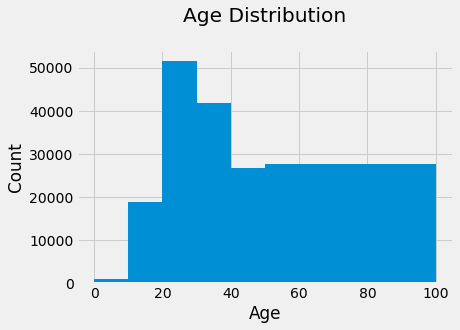

In [157]:
users.Age.hist(bins=[0, 10, 20, 30, 40, 50, 100])
plt.title('Age Distribution\n')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

The most active users are among those in their 20–30s.

Text(0.5, 1.0, 'Find outlier data in Age column')

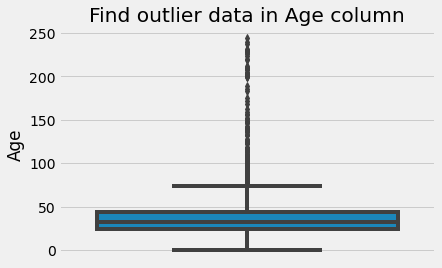

In [158]:
#Checking for outliers in the Users data
sns.boxplot(y='Age', data=users)
plt.title('Find outlier data in Age column')

In [159]:
print(sorted(users.Age.unique()))

[nan, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 118.0, 119.0, 123.0, 124.0, 127.0, 128.0, 132.0, 133.0, 136.0, 137.0, 138.0, 140.0, 141.0, 143.0, 146.0, 147.0, 148.0, 151.0, 152.0, 156.0, 157.0, 159.0, 162.0, 168.0, 172.0, 175.0, 183.0, 186.0, 189.0, 199.0, 200.0, 201.0, 204.0, 207.0, 208.0, 209.0, 210.0, 212.0, 219.0, 220.0, 223.0, 226.0

Age : 244
Ok we have Outlier data in Age

Let's find our unique value in Location column

In [160]:
users.Location.unique()

array(['nyc, new york, usa', 'stockton, california, usa',
       'moscow, yukon territory, russia', ...,
       'sergnano, lombardia, italy', 'stranraer, n/a, united kingdom',
       'tacoma, washington, united kingdom'], dtype=object)

In [161]:
users.Location.nunique()

57339

unique Value it's really hard to understand<br>
So lets create column Country

In [162]:
for i in users:
    users['Country']=users.Location.str.extract(r'\,+\s?(\w*\s?\w*)\"*$')   

In [163]:
users.Country.nunique()

529

In [164]:
#drop location column
users.drop('Location',axis=1,inplace=True)

In [165]:
users.head(2)

,User-ID,Age,Country
0,1,NaN,usa
1,2,18.0,usa


In [166]:
users.isnull().sum()

User-ID         0
Age        110762
Country       368
dtype: int64

In [167]:
users['Country']=users['Country'].astype('str')

In [168]:
a=list(users.Country.unique())
a=set(a)
a=list(a)
a = [x for x in a if x is not None]
a.sort()
print(a)

['', '01776', '02458', '19104', '23232', '30064', '85021', '87510', '_ brasil', 'a', 'aaa', 'adsgfdr', 'afghanistan', 'ahrensburg', 'alachua', 'albania', 'alderney', 'algeria', 'algérie', 'allen', 'ama lurra', 'america', 'american samoa', 'andorra', 'angola', 'antarctica', 'aotearoa', 'argentina', 'armenia', 'aroostook', 'aruba', 'asturies', 'auckland', 'austbritania', 'australia', 'australii', 'austria', 'autralia', 'az', 'azerbaijan', 'bademn würtemberg', 'bahamas', 'bahrain', 'baltimore', 'bangladesh', 'barbados', 'basilicata', 'basque country', 'bavaria', 'baxter', 'bbbzzzzz', 'belarus', 'belgi', 'belgique', 'belgium', 'belize', 'bell', 'benin', 'berguedà', 'bermuda', 'bernalillo', 'bfe', 'bhutan', 'bih', 'bkk', 'bladen', 'bolivia', 'bosnia', 'botswana', 'brasil', 'brazil', 'brunei', 'brunei darussalam', 'bucks', 'bulgaria', 'buncombe', 'burkina faso', 'burkinafasu', 'burlington', 'burma', 'butler', 'c', 'cadd0', 'calabria', 'california', 'cambodia', 'camden', 'cameroon', 'can', 'c

In [169]:
users['Country'].replace(['','01776','02458','19104','23232','30064','85021','87510','alachua','america','austria','autralia','cananda','geermany','italia','united kindgonm','united sates','united staes','united state','united states','us'],
                           ['other','usa','usa','usa','usa','usa','usa','usa','usa','usa','australia','australia','canada','germany','italy','united kingdom','usa','usa','usa','usa','usa'],inplace=True)

Text(0.5, 1.0, 'Count of users Country wise')

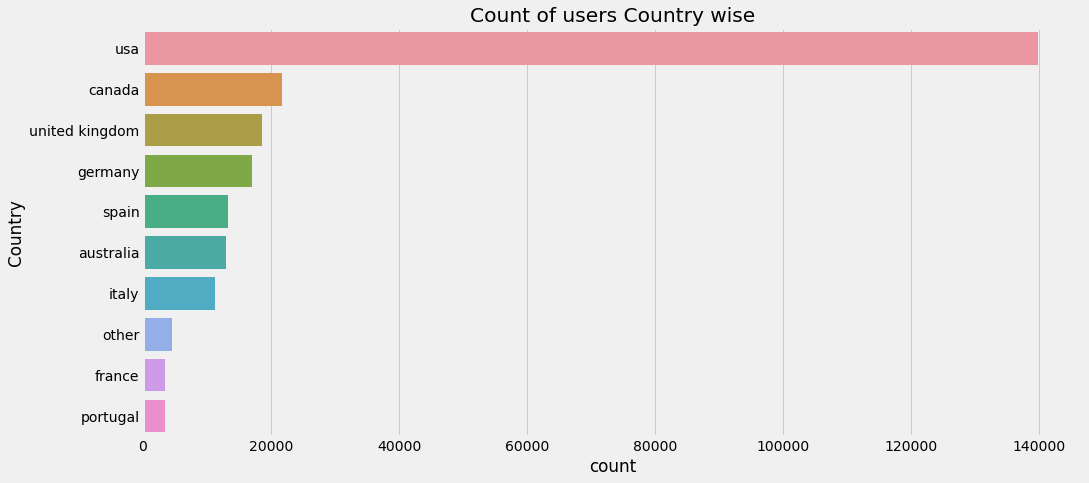

In [170]:
plt.figure(figsize=(15,7))
sns.countplot(y='Country',data=users,order=pd.value_counts(users['Country']).iloc[:10].index)
plt.title('Count of users Country wise')

Most number of users are from USA

Let's treat outliers in users age

Text(0.5, 1.0, 'Age Distribution Plot')

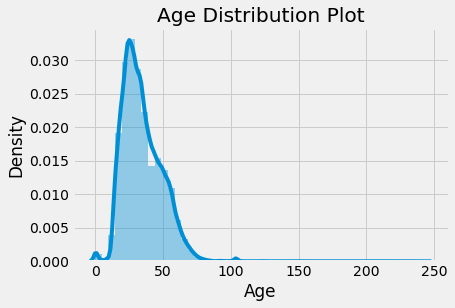

In [171]:
sns.distplot(users.Age)
plt.title('Age Distribution Plot')

Age value's below 5 and above 100 do not make much sense for our book rating case...hence replacing these by NaNs

In [172]:
# outlier data became NaN
users.loc[(users.Age > 100) | (users.Age < 5), 'Age'] = np.nan

In [173]:
users.isna().sum()

User-ID         0
Age        112010
Country         0
dtype: int64

Age has positive Skewness (right tail)
so we can use median to fill Nan values,
but for this we don't like to fill Nan value just for one range of age. To handle this we'll use country column to fill Nan.

In [174]:
users['Age'] = users['Age'].fillna(users.groupby('Country')['Age'].transform('median'))

In [175]:
users.isna().sum()

User-ID      0
Age        276
Country      0
dtype: int64

Still we have 276 Nan values let's fill them with mean

In [176]:
users['Age'].fillna(users.Age.mean(),inplace=True)

In [177]:
users.isna().sum()

User-ID    0
Age        0
Country    0
dtype: int64

In [178]:
users.head()

,User-ID,Age,Country
0,1,36.0,usa
1,2,18.0,usa
2,3,23.0,russia
3,4,17.0,portugal
4,5,32.0,united kingdom


### Book Dataset 

In [179]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


Top 10 Authors which have written the most books.

Text(0.5, 1.0, 'Top 10 Authors')

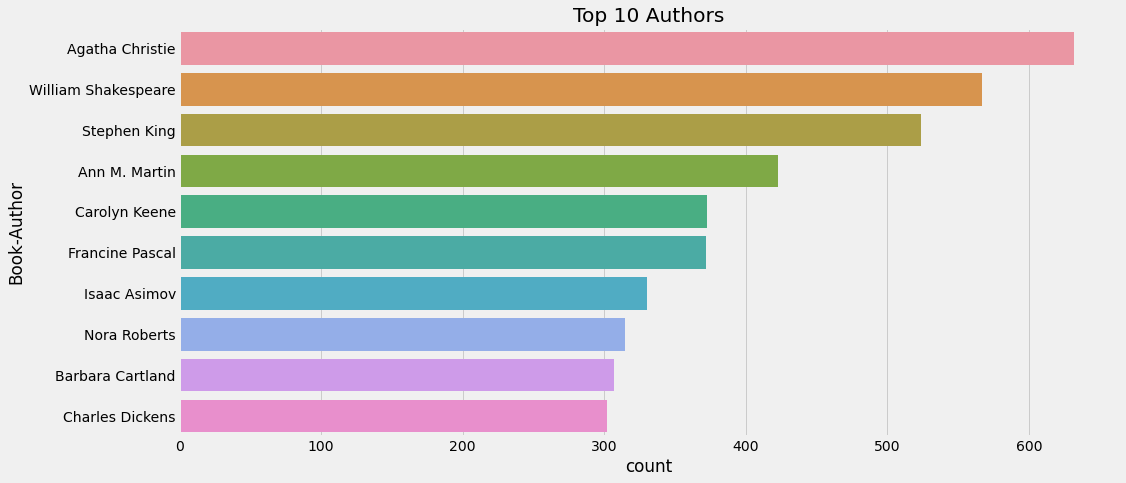

In [180]:
plt.figure(figsize=(15,7))
sns.countplot(y='Book-Author',data=books,order=pd.value_counts(books['Book-Author']).iloc[:10].index)
plt.title('Top 10 Authors')

Top 10 Publisher which have published the most books.

Text(0.5, 1.0, 'Top 10 Publishers')

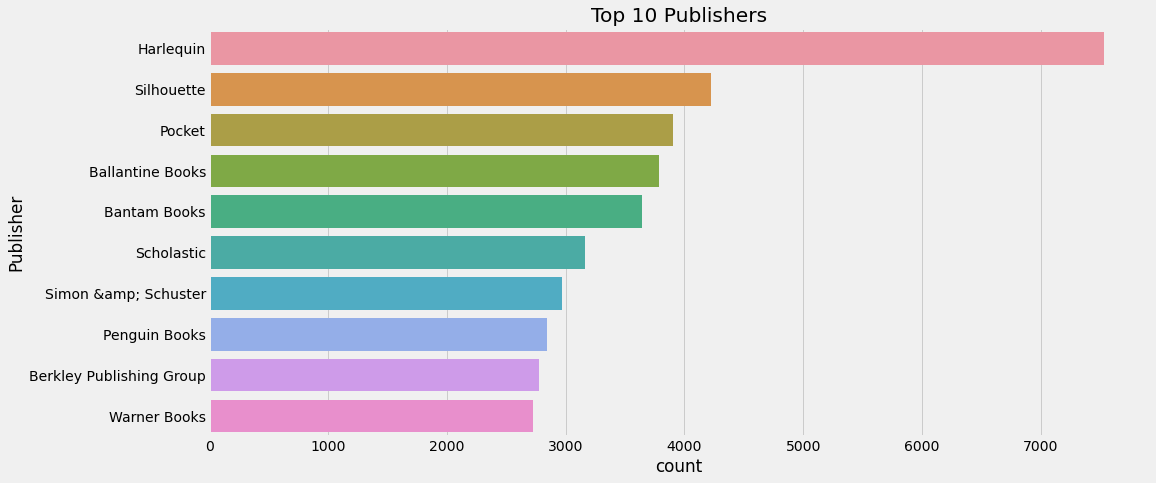

In [181]:
plt.figure(figsize=(15,7))
sns.countplot(y='Publisher',data=books,order=pd.value_counts(books['Publisher']).iloc[:10].index)
plt.title('Top 10 Publishers')

In [182]:
books['Year-Of-Publication']=books['Year-Of-Publication'].astype('str')
a=list(books['Year-Of-Publication'].unique())
a=set(a)
a=list(a)
a = [x for x in a if x is not None]
a.sort()
print(a)

['0', '1376', '1378', '1806', '1897', '1900', '1901', '1902', '1904', '1906', '1908', '1909', '1910', '1911', '1914', '1917', '1919', '1920', '1921', '1922', '1923', '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931', '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939', '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947', '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955', '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2008', '2010', '2011', '2012', '2020', '2021', '2024', '2026', '2030', '2037', '2038', '2050', 'DK Publishing Inc', 'Gallimard']


In [183]:
#investigating the rows having 'DK Publishing Inc' as yearOfPublication
books.loc[books['Year-Of-Publication'] == 'DK Publishing Inc',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


As it can be seen from above that there are some incorrect entries in Year-Of-Publication field. It looks like Publisher names 'DK Publishing Inc' and 'Gallimard' have been incorrectly loaded as Year-Of-Publication in dataset due to some errors in csv file 

In [184]:
#From above, it is seen that bookAuthor is incorrectly loaded with bookTitle, hence making required corrections
#ISBN '0789466953'
books.loc[books.ISBN == '0789466953','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '0789466953','Book-Author'] = "James Buckley"
books.loc[books.ISBN == '0789466953','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '0789466953','Book-Title'] = "DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)"

#ISBN '078946697X'
books.loc[books.ISBN == '078946697X','Year-Of-Publication'] = 2000
books.loc[books.ISBN == '078946697X','Book-Author'] = "Michael Teitelbaum"
books.loc[books.ISBN == '078946697X','Publisher'] = "DK Publishing Inc"
books.loc[books.ISBN == '078946697X','Book-Title'] = "DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)"

#rechecking
books.loc[(books.ISBN == '0789466953') | (books.ISBN == '078946697X'),:]
#corrections done

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",Michael Teitelbaum,2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...,http://images.amazon.com/images/P/078946697X.0...,NaN
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",James Buckley,2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...,http://images.amazon.com/images/P/0789466953.0...,NaN


In [185]:
#investigating the rows having 'Gallimard' as yearOfPublication
books.loc[books['Year-Of-Publication'] == 'Gallimard',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


In [186]:
#making required corrections as above, keeping other fields intact
books.loc[books.ISBN == '2070426769','Year-Of-Publication'] = 2003
books.loc[books.ISBN == '2070426769','Book-Author'] = "Jean-Marie Gustave Le ClÃ?Â©zio"
books.loc[books.ISBN == '2070426769','Publisher'] = "Gallimard"
books.loc[books.ISBN == '2070426769','Book-Title'] = "Peuple du ciel, suivi de 'Les Bergers"


books.loc[books.ISBN == '2070426769',:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers",Jean-Marie Gustave Le ClÃ?Â©zio,2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...,http://images.amazon.com/images/P/2070426769.0...,NaN


In [187]:
books['Year-Of-Publication']=pd.to_numeric(books['Year-Of-Publication'], errors='coerce')

print(sorted(books['Year-Of-Publication'].unique()))
#Now it can be seen that yearOfPublication has all values as integers

[0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908, 1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021, 2024, 2026, 2030, 2037, 2038, 2050]


The value 0 for Year-Of_Publication is invalid and as this dataset was published in 2004, We have assumed that the years after 2006 to be 
invalid and setting invalid years as NaN

In [188]:
books.loc[(books['Year-Of-Publication'] > 2006) | (books['Year-Of-Publication'] == 0),'Year-Of-Publication'] = np.NAN

#replacing NaNs with median value of Year-Of-Publication
books['Year-Of-Publication'].fillna(round(books['Year-Of-Publication'].median()), inplace=True)

In [189]:
#dropping last three columns containing image URLs which will not be required for analysis
books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1,inplace=True)

In [190]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
dtype: int64

In [191]:
#exploring 'publisher' column
books.loc[books.Publisher.isnull(),:]
#two NaNs

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002.0,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001.0,NaN


In [192]:
#Filling Nan of Publisher with others
books.Publisher.fillna('other',inplace=True)

In [193]:
#exploring 'Book-Author' column
books.loc[books['Book-Author'].isnull(),:]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995.0,Edinburgh Financial Publishing


In [194]:
#Filling Nan of Book-Author with others
books['Book-Author'].fillna('other',inplace=True)

In [195]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

### Ratings Dataset

In [196]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


Ratings dataset should have books only which exist in our books dataset

In [197]:
ratings_new = ratings[ratings.ISBN.isin(books.ISBN)]
ratings.shape,ratings_new.shape

((1149780, 3), (1031136, 3))

It can be seen that many rows having book ISBN not part of books dataset got dropped off

Ratings dataset should have ratings from users which exist in users dataset.

In [198]:
print("Shape of dataset before dropping",ratings.shape)
ratings_new = ratings_new[ratings_new['User-ID'].isin(users['User-ID'])]
print("shape of dataset after dropping",ratings_new.shape)

Shape of dataset before dropping (1149780, 3)
shape of dataset after dropping (1031136, 3)


It can be seen that no new user was there in ratings dataset.

Let's see how the ratings are distributed

<AxesSubplot:xlabel='Book-Rating', ylabel='count'>

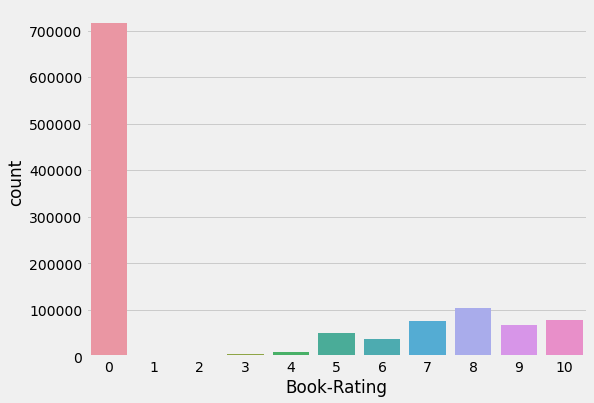

In [199]:
plt.figure(figsize=(8,6))
sns.countplot(x="Book-Rating", data=ratings)

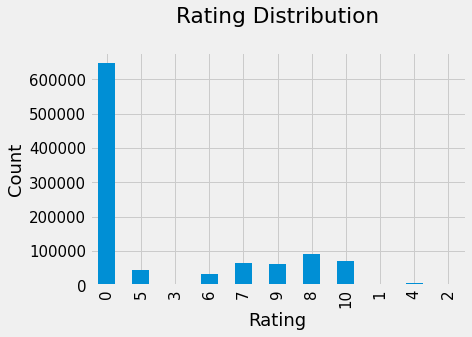

In [200]:
plt.rc("font", size=15)
ratings_new['Book-Rating'].value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

The ratings are very unevenly distributed, and the vast majority of ratings are 0 .As quoted in the description of the dataset - BX-Book-Ratings contains the book rating information. Ratings are either explicit, expressed on a scale from 1-10 higher values denoting higher appreciation, or implicit, expressed by 0.Hence segragating implicit and explict ratings datasets

In [201]:
#Hence segragating implicit and explict ratings datasets
ratings_explicit = ratings_new[ratings_new['Book-Rating'] != 0]
ratings_implicit = ratings_new[ratings_new['Book-Rating'] == 0]

In [202]:
print('ratings_explicit dataset shape',ratings_explicit.shape)
print('ratings_implicit dataset',ratings_implicit.shape)

ratings_explicit dataset shape (383842, 3)
ratings_implicit dataset (647294, 3)


<AxesSubplot:xlabel='Book-Rating', ylabel='count'>

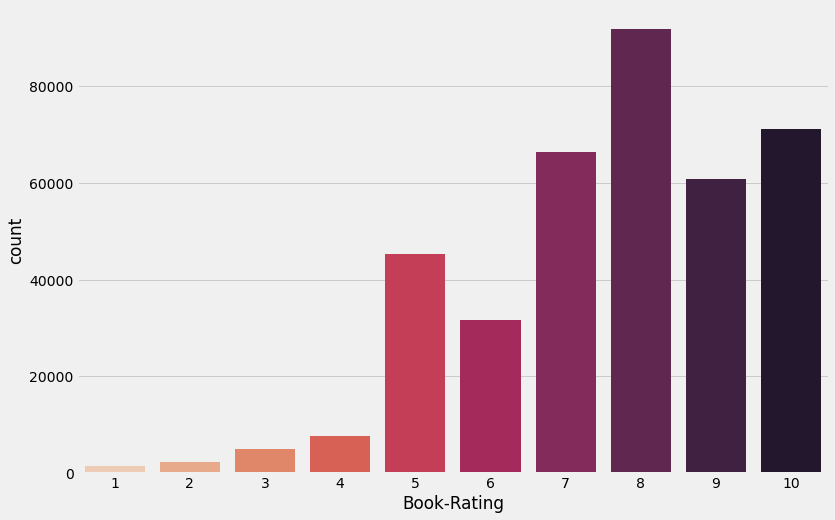

In [203]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12, 8))
sns.countplot(data=ratings_explicit , x='Book-Rating', palette='rocket_r')

It can be observe that higher ratings are more common amongst users and rating 8 has been rated highest number of times

Let's find the top 5 books which are rated by most number of users.

In [204]:
rating_count = pd.DataFrame(ratings_explicit.groupby('ISBN')['Book-Rating'].count())
rating_count.sort_values('Book-Rating', ascending=False).head()

,Book-Rating
ISBN,
0316666343,707
0971880107,581
0385504209,487
0312195516,383
0060928336,320


The book with ISBN '0316666343' received the most rating counts. Let’s find out what book it is, and what books are in the top 5.

In [205]:
most_rated_books = pd.DataFrame(['0316666343', '0971880107', '0385504209', '0312195516', '0060928336'], index=np.arange(5), columns = ['ISBN'])
most_rated_books_summary = pd.merge(most_rated_books, books, on='ISBN')
most_rated_books_summary

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0316666343,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown"
1,0971880107,Wild Animus,Rich Shapero,2004.0,Too Far
2,0385504209,The Da Vinci Code,Dan Brown,2003.0,Doubleday
3,0312195516,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA
4,0060928336,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial


The book that received the most rating counts in this data set is Rich Shapero’s “Wild Animus”. And there is something in common among these five books that received the most rating counts — they are all novels. So it is conclusive that novels are popular and likely receive more ratings. 

In [206]:
# Create column Rating average 
ratings_explicit['Avg_Rating']=ratings_explicit.groupby('ISBN')['Book-Rating'].transform('mean')
# Create column Rating sum
ratings_explicit['Total_No_Of_Users_Rated']=ratings_explicit.groupby('ISBN')['Book-Rating'].transform('count')

In [207]:
ratings_explicit.head()

,User-ID,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated
1,276726,0155061224,5,5.000000,1
3,276729,052165615X,3,3.000000,1
4,276729,0521795028,6,6.000000,1
8,276744,038550120X,7,7.580247,81
16,276747,0060517794,9,8.000000,30


### Merging all datasets

In [208]:
Final_Dataset=users.copy()
Final_Dataset=pd.merge(Final_Dataset,ratings_explicit,on='User-ID')
Final_Dataset=pd.merge(Final_Dataset,books,on='ISBN')

In [209]:
Final_Dataset.head()

,User-ID,Age,Country,ISBN,Book-Rating,Avg_Rating,Total_No_Of_Users_Rated,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,8,33.0,canada,0002005018,5,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
1,11676,28.0,nan,0002005018,8,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
2,67544,30.0,canada,0002005018,8,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
3,116866,32.0,other,0002005018,9,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada
4,123629,33.0,canada,0002005018,9,7.666667,9,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada


In [210]:
missing_values(Final_Dataset)

,index,Missing Values,% of Total Values,Data_type
0,User-ID,0,0.0,int64
1,Age,0,0.0,float64
2,Country,0,0.0,object
3,ISBN,0,0.0,object
4,Book-Rating,0,0.0,int64
5,Avg_Rating,0,0.0,float64
6,Total_No_Of_Users_Rated,0,0.0,int64
7,Book-Title,0,0.0,object
8,Book-Author,0,0.0,object
9,Year-Of-Publication,0,0.0,float64


In [211]:
Final_Dataset.shape

(383842, 11)

In [212]:
Final_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383842 entries, 0 to 383841
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   User-ID                  383842 non-null  int64  
 1   Age                      383842 non-null  float64
 2   Country                  383842 non-null  object 
 3   ISBN                     383842 non-null  object 
 4   Book-Rating              383842 non-null  int64  
 5   Avg_Rating               383842 non-null  float64
 6   Total_No_Of_Users_Rated  383842 non-null  int64  
 7   Book-Title               383842 non-null  object 
 8   Book-Author              383842 non-null  object 
 9   Year-Of-Publication      383842 non-null  float64
 10  Publisher                383842 non-null  object 
dtypes: float64(3), int64(3), object(5)
memory usage: 35.1+ MB


## Recommendation Systems

In [215]:
bookName = input("Enter a book name: ")
number = int(input("Enter number of books to recommend: "))

# Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))

Enter a book name: Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))
Enter number of books to recommend: 5


### Popularity Based Recommendations

#### 1. Top in whole collection

In [227]:
def popularity_based(dataframe, n):
    if n >= 1 and n <= len(dataframe):
        data = pd.DataFrame(dataframe.groupby('ISBN')['Book-Rating'].count()).sort_values('Book-Rating', ascending=False).head(n)
#         print(data)
        result = pd.merge(data, books, on='ISBN')
        return result
    return "Invalid number of books entered!!"

In [228]:
print("Top", number, "Popular books are: ")
popularity_based(Final_Dataset, number)

Top 5 Popular books are: 


,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0316666343,707,The Lovely Bones: A Novel,Alice Sebold,2002.0,"Little, Brown"
1,0971880107,581,Wild Animus,Rich Shapero,2004.0,Too Far
2,0385504209,487,The Da Vinci Code,Dan Brown,2003.0,Doubleday
3,0312195516,383,The Red Tent (Bestselling Backlist),Anita Diamant,1998.0,Picador USA
4,0060928336,320,Divine Secrets of the Ya-Ya Sisterhood: A Novel,Rebecca Wells,1997.0,Perennial


#### 2. Books by same author, publisher of given book name

In [229]:
def printBook(k, n):
    z = k['Book-Title'].unique()
    for x in range(len(z)):
        print(z[x])
        if x >= n-1:
            break

In [230]:
def get_books(dataframe, name, n):
    print("\nBooks by same Author:\n")
    au = dataframe['Book-Author'].unique()

    data = Final_Dataset[Final_Dataset['Book-Title'] != name]

    if au[0] in list(data['Book-Author'].unique()):
        k2 = data[data['Book-Author'] == au[0]]
    k2 = k2.sort_values(by=['Book-Rating'])
    printBook(k2, n)

    print("\n\nBooks by same Publisher:\n")
    au = dataframe['Publisher'].unique()

    if au[0] in list(data['Publisher'].unique()):
        k2 = pd.DataFrame(data[data['Publisher'] == au[0]])
    k2=k2.sort_values(by=['Book-Rating']) 
    printBook(k2, n)

In [231]:
if bookName in list(Final_Dataset['Book-Title'].unique()):
    d = Final_Dataset[Final_Dataset['Book-Title'] == bookName]
    get_books(d, bookName, number)
else:
    print("Invalid Book Name!!")


Books by same Author:

Harry Potter and the Goblet of Fire (Book 4)
Harry Potter y el cÃ¡liz de fuego
Harry Potter and the Order of the Phoenix (Book 5)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)


Books by same Publisher:

The Seeing Stone
The Slightly True Story of Cedar B. Hartley: Who Planned to Live an Unusual Life
Harry Potter and the Chamber of Secrets (Harry Potter)
The Story of the Seagull and the Cat Who Taught Her To Fly
The Mouse and His Child


#### 3.Average Weighted Ratings

As the name suggests Popularity based recommendation system works with the trend. It basically uses the items which are in trend right now. For example, if any book which is usually bought by every new user then there are chances that it may suggest that book to the user who just signed up.
Book weighted avg formula:
Weighted Rating(WR)=[vR/(v+m)]+[mC/(v+m)]
where,
v is the number of votes for the books;
m is the minimum votes required to be listed in the chart;
R is the average rating of the book; and
C is the mean vote across the whole report.
Now we find the values of v,m,R,C.

In [237]:
C= Final_Dataset['Avg_Rating'].mean()
m= Final_Dataset['Total_No_Of_Users_Rated'].quantile(0.90)
Top_Books = Final_Dataset.loc[Final_Dataset['Total_No_Of_Users_Rated'] >= m]
print(f'C={C} , m={m}')
Top_Books.shape

C=7.626700569504765 , m=64.0


(38570, 11)

Here we used 90th percentile as our cutoff. In other words, for a book to feature in the charts, it must have more votes than at least 90% of the books in the list.<br>
We see that there are 38570 books which qualify to be in this list. Now, we need to calculate our metric for each qualified book. To do this, we will define a function, weighted_rating() and define a new feature score, of which we’ll calculate the value by applying this function to our DataFrame of qualified books:


In [243]:
def weighted_rating(x, m=m, C=C):
    v = x['Total_No_Of_Users_Rated']
    R = x['Avg_Rating']
    return (v/(v+m) * R) + (m/(m+v) * C)
    
 
Top_Books['Score'] = Top_Books.apply(weighted_rating,axis=1)
 
 
#Sorting books based on score calculated above
Top_Books = Top_Books.sort_values('Score', ascending=False)

In [244]:
#Keeping only one entry of each book
Top_Books=Top_Books.sort_values('Score', ascending=False).drop_duplicates('ISBN').sort_index()
cm=sns.light_palette('red',as_cmap=True)
#Sorting books based on score calculated above
Top_Books = Top_Books.sort_values('Score', ascending=False)

#Printing the top 20 books
Top_Books[['Book-Title', 'Total_No_Of_Users_Rated', 'Avg_Rating', 'Score']].reset_index(drop=True).head(number).style.background_gradient(cmap=cm)

,Book-Title,Total_No_Of_Users_Rated,Avg_Rating,Score
0,Harry Potter and the Goblet of Fire (Book 4),137,9.262774,8.741835
1,Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),313,8.939297,8.716469
2,Harry Potter and the Order of the Phoenix (Book 5),206,9.033981,8.700403
3,To Kill a Mockingbird,214,8.943925,8.640679
4,Harry Potter and the Prisoner of Azkaban (Book 3),133,9.082707,8.609690


The Popularity based recommender provide a general chart of recommended books to all the users. They are not sensitive to the interests and tastes of a particular user.

#### Content Based Recommendation

In [245]:
Final_Dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 383842 entries, 0 to 383841
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   User-ID                  383842 non-null  int64  
 1   Age                      383842 non-null  float64
 2   Country                  383842 non-null  object 
 3   ISBN                     383842 non-null  object 
 4   Book-Rating              383842 non-null  int64  
 5   Avg_Rating               383842 non-null  float64
 6   Total_No_Of_Users_Rated  383842 non-null  int64  
 7   Book-Title               383842 non-null  object 
 8   Book-Author              383842 non-null  object 
 9   Year-Of-Publication      383842 non-null  float64
 10  Publisher                383842 non-null  object 
dtypes: float64(3), int64(3), object(5)
memory usage: 35.1+ MB


In [248]:
popularity_threshold = 80
popular_book = Final_Dataset[Final_Dataset['Total_No_Of_Users_Rated'] >= popularity_threshold]
popular_book = popular_book.reset_index(drop = True)
popular_book.shape

(31048, 11)

In [249]:
tf = TfidfVectorizer(ngram_range=(1, 2), min_df = 1, stop_words='english')
tfidf_matrix = tf.fit_transform(popular_book['Book-Title'])
tfidf_matrix.shape

(31048, 905)

In [250]:
normalized_df = tfidf_matrix.astype(np.float32)
cosine_similarities = cosine_similarity(normalized_df, normalized_df)
cosine_similarities.shape

(31048, 31048)

In [251]:
print("Recommended Books:\n")
isbn = books.loc[books['Book-Title'] == bookName].reset_index(drop = True).iloc[0]['ISBN']
content = []

idx = popular_book.index[popular_book['ISBN'] == isbn].tolist()[0]
similar_indices = cosine_similarities[idx].argsort()[::-1]
similar_items = []
for i in similar_indices:
    if popular_book['Book-Title'][i] != bookName and popular_book['Book-Title'][i] not in similar_items and len(similar_items) < number:
        similar_items.append(popular_book['Book-Title'][i])
        content.append(popular_book['Book-Title'][i])

for book in similar_items:
    print(book)

Recommended Books:

Harry Potter and the Sorcerer's Stone (Book 1)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Order of the Phoenix (Book 5)


#### Nearest Neighbours Based 

In [256]:
data = (Final_Dataset.groupby(by = ['Book-Title'])['Book-Rating'].count().reset_index().
        rename(columns = {'Book-Rating': 'Total-Rating'})[['Book-Title', 'Total-Rating']])

result = pd.merge(data, Final_Dataset, on='Book-Title')
result = result[result['Total-Rating'] >= popularity_threshold]
result = result.reset_index(drop = True)

matrix = result.pivot_table(index = 'Book-Title', columns = 'User-ID', values = 'Book-Rating').fillna(0)
up_matrix = csr_matrix(matrix)

In [257]:
model = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model.fit(up_matrix)

distances, indices = model.kneighbors(matrix.loc[bookName].values.reshape(1, -1), n_neighbors = number+1)
print("\nRecommended books:\n")
for i in range(0, len(distances.flatten())):
    if i > 0:
        print(matrix.index[indices.flatten()[i]]) 


Recommended books:

Harry Potter and the Chamber of Secrets (Book 2)
Harry Potter and the Prisoner of Azkaban (Book 3)
Harry Potter and the Goblet of Fire (Book 4)
Harry Potter and the Order of the Phoenix (Book 5)
The Fellowship of the Ring (The Lord of the Rings, Part 1)
